In [ ]:
# install wandb
!pip install wandb --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 4.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2c1518bbfe7ac9a9f339f562ca377f001c4ea10cc21c91a5deec8d3f88271ad0
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
#do login in wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# import libraries
import os
import scipy.io
import random
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pickle
from torch.optim import lr_scheduler

# ensure determinstic behavior
# torch.backends.cudnn.deterministic = True

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# remove warnings
import warnings
warnings.filterwarnings('ignore')

cuda


# Question 1

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, transform):
    self.data = scipy.io.loadmat('/content/drive/MyDrive/CV datasets/train_32x32.mat')
    print(self.data['X'].shape)
    self.X = np.moveaxis(self.data['X'], 3, 0)
    print(self.X.shape)
    self.y = self.data['y'].reshape(-1)
    self.y[self.y == 10] = 0
    print(self.y.shape)
    self.transform = transform
  

  def __len__(self):
    return self.data['X'].shape[-1]


  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]
    if self.transform:
      image = self.transform(image)
    return image, label


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
svhn_dataset = ImageDataset(transform)

(32, 32, 3, 73257)
(73257, 32, 32, 3)
(73257,)


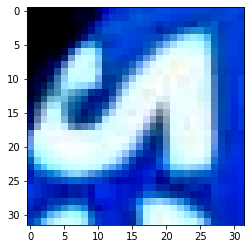

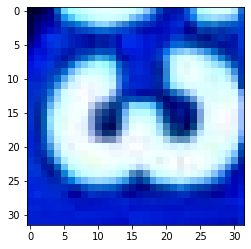

In [ ]:
# plot images
for i in range(2, 4):
  plt.imshow(svhn_dataset[i][0].permute(2, 1, 0))
  plt.show()

### Custom Dataloaders for train val test split

In [ ]:
# randomply split the data
train_set, val_set, test_set = torch.utils.data.random_split(svhn_dataset, [0.7, 0.2, 0.1])

# dataloader created
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)

### Visulization of data distribution of class labels of train and val set

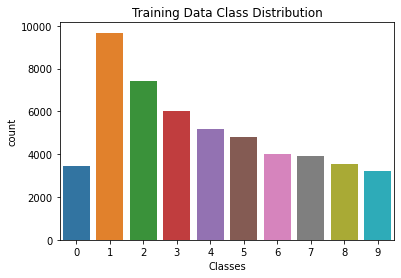

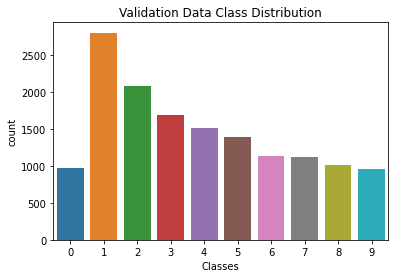

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


train_labels = [sample[1] for sample in train_set]
val_labels = [sample[1] for sample in val_set]


sns.countplot(train_labels)
plt.title("Training Data Class Distribution")
plt.xlabel("Classes")
plt.show()

sns.countplot(val_labels)
plt.title("Validation Data Class Distribution")
plt.xlabel("Classes")
plt.show()

### Custom Class for CNN

In [ ]:
import torch.nn.functional as F


class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.fc1 = nn.Linear(65536, 10)
    nn.init.kaiming_uniform_(self.conv1.weight)
    nn.init.kaiming_uniform_(self.conv2.weight)
    nn.init.kaiming_uniform_(self.fc1.weight)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x


# model intitialize
model = ConvNet().to(device)

# Training Function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs, train_dataloader, val_dataloader):
  # command to log loss and gredients
  wandb.watch(model)
  total_train_loss = []
  total_val_loss = []


  # training loop
  for x in range(epochs):
    batch_train_loss = 0
    batch_val_loss = 0
    num_batches = 0

    for i, (images, labels)  in enumerate(train_dataloader):
      images = images.to(device)
      labels = labels.to(device)
    
      # forward pass
      predicted = model(images)
      loss = criterion(predicted, labels)

      # backward pass
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      batch_train_loss += loss.item()
      num_batches += 1

    print("train loss :", loss.item())
    # scheduler.step()
    batch_train_loss /= num_batches
    total_train_loss.append(batch_train_loss)

    
    # validation accuracy
    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      count = 0

      for i, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        
        loss = criterion(output, labels)
        batch_val_loss += loss.item()
        count += 1

        _, predicted = torch.max(output.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
      
      acc = 100 * n_correct / n_samples
      batch_val_loss /= count
      total_val_loss.append(batch_val_loss) 
      wandb.log({"accuracy": acc, "Train loss": batch_train_loss, "Validation loss": batch_val_loss})
      print("val loss :", batch_val_loss)
      print("accuracy is :", acc)
      print()
    
  print('Finished Training')

## Testing Function

In [ ]:
def test_model(model, test_dataloader):
  # testing loop
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    labels_list = []
    predicted_list = []
    misclassification = []

    for i, (images, labels) in enumerate(test_dataloader):
      images = images.to(device)
      labels = labels.to(device)
      
      output = model(images)
      _, predicted = torch.max(output, 1)
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()
      
      # find misclassified images
      for label, prediction in zip(labels, predicted):
        if label != prediction:
          misclassification.append((images[prediction], label, prediction))
      
      labels_list.extend(labels.data.detach().cpu().numpy().tolist())
      predicted_list.extend(predicted.detach().cpu().numpy().tolist())

    # find accuracy and f1 score
    acc = 100 * (n_correct / n_samples)
    f1score = f1_score(labels.data.detach().cpu().flatten(), predicted.detach().cpu().flatten(), average="micro")*100
    print("accuracy is :", acc)
    print("f1 score is :", f1score)
  
  # plot confusion matrix
  wandb.sklearn.plot_confusion_matrix(labels_list, predicted_list)
  
  # total misclassified images
  len(misclassification)
  return misclassification

## Train Custom Created CNN model

In [ ]:
# set hyperparamters
batch_size = 64
learning_rate = 0.0005
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='baseline')

# add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# train CNN models
train_model(model, criterion, optimizer, scheduler, epochs, train_dataloader, val_dataloader)
print()

# save cnn model 
filename = '/content/drive/MyDrive/CV datasets/cnn.sav'
pickle.dump(model, open(filename, 'wb'))
print("model saved sucessfully")

train loss : 1.4447766542434692
val loss : 1.5249067680283925
accuracy is : 54.99590499590499

train loss : 0.7504454255104065
val loss : 0.9325518915226366
accuracy is : 73.09582309582309

train loss : 0.7183089852333069
val loss : 0.776202678810561
accuracy is : 77.77777777777777

train loss : 0.7144748568534851
val loss : 0.7096950203570737
accuracy is : 79.35435435435436

train loss : 0.7928049564361572
val loss : 0.6874288312732914
accuracy is : 80.21430521430521

train loss : 0.5069018006324768
val loss : 0.6591835888712687
accuracy is : 81.14933114933115

train loss : 0.28017887473106384
val loss : 0.6430797246345786
accuracy is : 81.84548184548184

train loss : 0.9466454386711121
val loss : 0.6373758309532982
accuracy is : 81.81818181818181

train loss : 0.32223406434059143
val loss : 0.6400527507717433
accuracy is : 81.77723177723178

train loss : 0.3143445551395416
val loss : 0.6352120833105396
accuracy is : 82.11848211848212

Finished Training

model saved sucessfully


## Test custom CNN model on Test set

In [ ]:
# load the saved model
# batch_size = 64
# learning_rate = 0.0005
# epochs = 10

# # Intialize the wandb run
# wandb.init(entity='jk12', project="A1", name='baseline')

# # add config to run
# wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


filename = '/content/drive/MyDrive/CV datasets/cnn.sav'
loaded_model = pickle.load(open(filename, 'rb')).to(device)


# test model on test set
misclassification_CNN = test_model(loaded_model, test_dataloader)

accuracy is : 83.04436860068259
f1 score is : 75.86206896551724


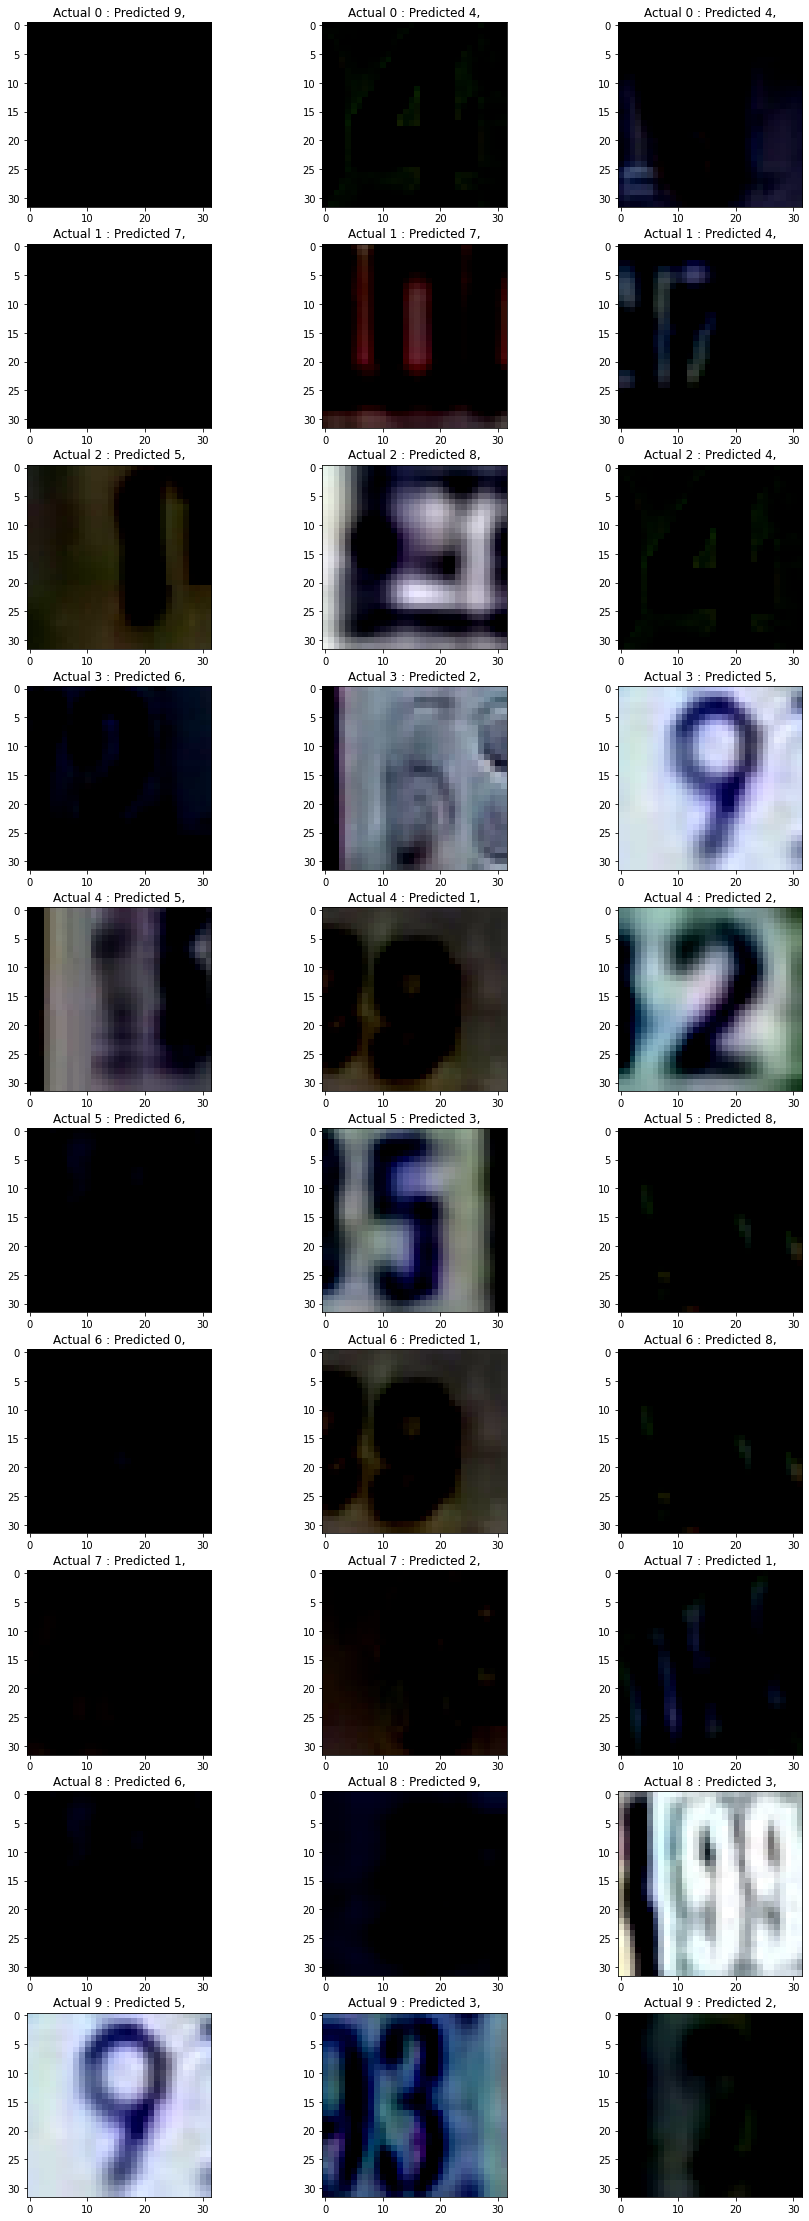

In [ ]:
# show the misclassified images for each classes
plt.figure(figsize=(15, 40))
img_num = 1
for i in range(10):
  count = 0
  for image, label, pred in misclassification:
    if count >= 3:
      break
    if label == i:
      ax = plt.subplot(10, 3, img_num)
      ax.imshow(image.cpu().permute(1, 2, 0))
      ax.set_title("Actual {} : Predicted {},".format(label, pred))
      img_num += 1
      count += 1

#### Model is not performing better because in misclassieid images actaul image and labels both are diffrent and sime times there can be more thant 1 number also prensent in the image. so model is not able classified this images.

## Fine Tune Pretrain model

In [ ]:
from torchvision import models


# load pretrain model
resnet_model = models.resnet18(pretrained=True)
num_features = resnet_model.fc.in_features


# add final layer
resnet_model.fc1 = nn.Linear(num_features, 10)
# torch.nn.init.kaiming_uniform_(resnet_model.fc1.weight)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# set loss function, optimizer and scheduler
epochs = 5
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='resnet')


# add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# train Resnet18 models
train_model(resnet_model, criterion, optimizer, scheduler, epochs, train_dataloader, val_dataloader)
print()
print()


# save resnet18 trained model
filename = '/content/drive/MyDrive/CV datasets/resnet18.sav'
pickle.dump(resnet_model, open(filename, 'wb'))
print("model saved")

## Test Finetuned Resnet Model

In [ ]:
# load resnet18 model
filename = '/content/drive/MyDrive/CV datasets/resnet18.sav'
resnet_model = pickle.load(open(filename, 'rb'))
print("model loaded successfully")
print()


batch_size = 64
learning_rate = 0.0005
epochs = 10


# Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='baseline')

# add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# test Resnet18 model
resnet_model = resnet_model.to(device)
misclassification_resnet = test_model(resnet_model, test_dataloader)

# close wandb
wandb.finish()

model loaded successfully



Train loss,█▄▂▂▂▁▁▁▁▁
Validation loss,█▃▂▂▁▁▁▁▁▁
accuracy,▁▆▇▇██████
Train loss,0.51264
Validation loss,0.63521
accuracy,82.11848


accuracy is : 93.78839590443687
f1 score is : 86.20689655172413


## Feature Extraction from Resnet18

In [ ]:
resnet_features = torch.nn.Sequential(*list(resnet_model.children())[:-2])

### Train data feature extraction

In [ ]:
train_features = []
train_labels = []

i = 0
for images, labels in train_dataloader:
  if i > 400:
    break
  images = images.to(device)
  label = labels.to(device)
  i += 1
  temp = resnet_features(images).cpu().detach().numpy().reshape(64, 512)
  train_features.append(temp)
  train_labels.append(labels.cpu().detach().numpy())


train_features = np.vstack(train_features)
train_labels = np.array(train_labels).flatten()
print(train_features.shape)
print(train_labels.shape)

(25664, 512)
(25664,)


### Validation data feature extraction

In [ ]:
val_features = []
val_labels = []

i = 0
for images, labels in val_dataloader:
  images = images.to(device)
  labels = labels.to(device)
  if i == len(val_dataloader) - 1:
    break
  i += 1
  temp = resnet_features(images).cpu().detach().numpy().reshape(64, 512)
  val_features.append(temp)
  val_labels.append(labels.cpu().detach().numpy())


val_features = np.vstack(val_features)
val_labels = np.array(val_labels).flatten()
print(val_features.shape)
print(val_labels.shape)

(14592, 512)
(14592,)


## Plot 2D TSNE plots of train features

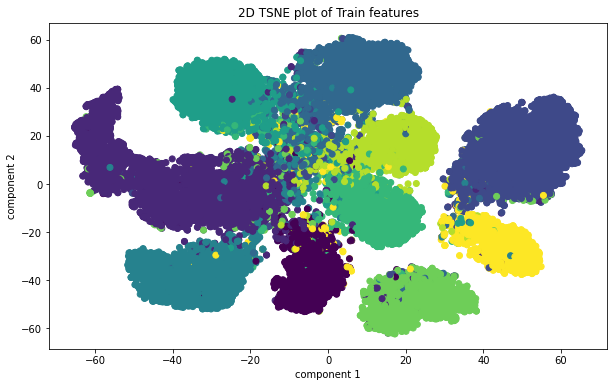

In [ ]:
plt.figure(figsize=(10, 6))
train_embeddings = TSNE(n_components=2).fit_transform(train_features)
plt.scatter(train_embeddings[:, 0], train_embeddings[:, 1], c=train_labels)
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("2D TSNE plot of Train features")
plt.show()

## 2D tsne plot of Validation features

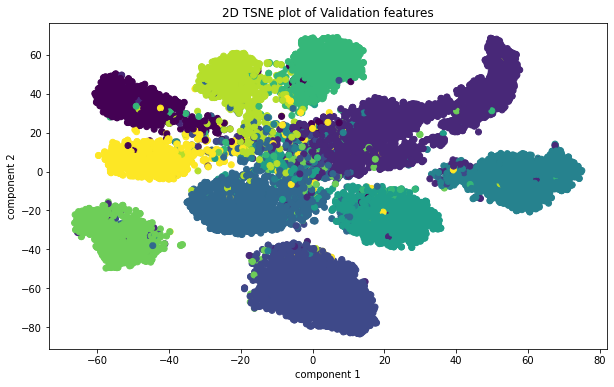

In [ ]:
plt.figure(figsize=(10, 6))
val_embeddings = TSNE(n_components=2).fit_transform(val_features)
plt.scatter(val_embeddings[:, 0], val_embeddings[:, 1], c=val_labels)
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("2D TSNE plot of Validation features")
plt.show()

## Plot 3D TSNE of validation features

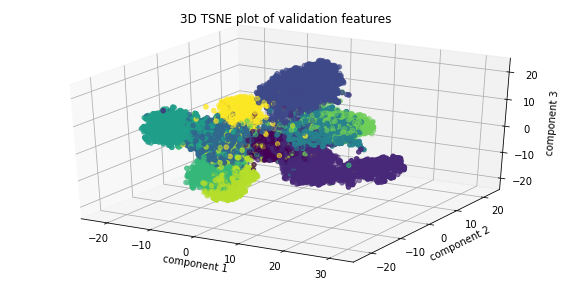

In [ ]:
ax = plt.figure(figsize=(10, 5)).gca(projection='3d')

val_embeddings = TSNE(n_components=3).fit_transform(val_features)
ax.scatter(val_embeddings[:, 0], val_embeddings[:, 1], val_embeddings[:, 2], c=val_labels)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.title("3D TSNE plot of validation features")
plt.show()

### Data Augmentation


In [ ]:
from torchvision import transforms

# compose data augmentation techniques
augmentation_transform = transforms.Compose([transforms.ToTensor(), 
                                             transforms.RandomAdjustSharpness(1.9),
                                             transforms.CenterCrop(28),
                                             transforms.RandomAutocontrast(0.9),
                                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# dataset object created
svhn_augmented_dataset = ImageDataset(augmentation_transform)

# dataloader for augmentated dataset
augmented_train_set, augmented_val_set, augmented_test_set = torch.utils.data.random_split(svhn_dataset, [0.7, 0.2, 0.1])
print(type(augmented_train_set))

# dataloader created
augmented_train_dataloader = DataLoader(augmented_train_set, batch_size=64, shuffle=True)
augmented_val_dataloader = DataLoader(augmented_val_set, batch_size=64, shuffle=True)
augmented_test_dataloader = DataLoader(augmented_test_set, batch_size=64, shuffle=False)
print(augmented_train_dataloader)

(32, 32, 3, 73257)
(73257, 32, 32, 3)
(73257,)
<class 'torch.utils.data.dataset.Subset'>


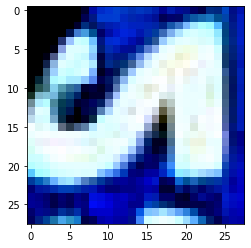

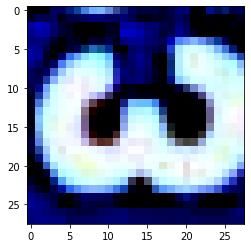

In [ ]:
# show the augmented data images
for i in range(2, 4):
  plt.imshow(svhn_augmented_dataset[i][0].permute(2, 1, 0))
  plt.show()

## Train augmented dataset on the Resnet18

In [ ]:
# set loss function, optimizer and scheduler
epochs = 10
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='resnet_augmented')


# add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# train Resnet18 models
train_model(resnet_model, criterion, optimizer, scheduler, epochs, augmented_train_dataloader, augmented_val_dataloader)
print()
print()


# save resnet18 trained model
filename = '/content/drive/MyDrive/CV datasets/augmented_resnet18.sav'
pickle.dump(resnet_model, open(filename, 'wb'))
print("model saved")

train loss : 0.11010564118623734
val loss : 0.2938117748329733
accuracy is : 92.25361725361725

train loss : 0.06420845538377762
val loss : 0.29257948872303857
accuracy is : 92.9019929019929

train loss : 0.9358615279197693
val loss : 0.31724439399503984
accuracy is : 92.75184275184276

train loss : 0.6711037158966064
val loss : 0.30589307049354414
accuracy is : 92.86104286104286

train loss : 0.010718856006860733
val loss : 0.3278926290392746
accuracy is : 93.01119301119301

train loss : 0.13966986536979675
val loss : 0.351353874950625
accuracy is : 92.66994266994267

train loss : 0.5468884706497192
val loss : 0.34266365382934244
accuracy is : 92.72454272454273

train loss : 0.2235264927148819
val loss : 0.34661970287154725
accuracy is : 92.96341796341797

train loss : 0.001803151099011302
val loss : 0.35560221512960555
accuracy is : 93.10674310674311

train loss : 0.045441173017024994
val loss : 0.35995419601621065
accuracy is : 92.94294294294295

Finished Training


model saved


### Testing on Resnet18 which was train on augmented data

In [ ]:
# load resnet18 model
filename = '/content/drive/MyDrive/CV datasets/augmented_resnet18.sav'
resnet_model = pickle.load(open(filename, 'rb'))
print("model loaded successfully")
print()


batch_size = 64
learning_rate = 0.0005
epochs = 10


# Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='resnet_augmented')

# add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# test Resnet18 model
resnet_model = resnet_model.to(device)
misclassification_augmented = test_model(resnet_model, augmented_test_dataloader)

# close wandb
wandb.finish()

model loaded successfully



Train loss,█▆▅▅▃▃▃▂▂▁
Validation loss,▁▁▄▂▅▇▆▇██
accuracy,▁▆▅▆▇▄▅▇█▇
Train loss,0.02475
Validation loss,0.35995
accuracy,92.94294


accuracy is : 93.46075085324233
f1 score is : 96.55172413793103


## Compare and Comment on the performence of all models

In [ ]:
### Basic CNN models test accuracy is 83 %.
### Pretrain Resnet18 model test accuracy is around 90 %.
### Resnet18 with augmented data model's test accuracy is 93 %.

### As we can see basic CNN model is not capturing all types of features and making 17 % of images as misclassified.

### Resnet18 pretrain model trained on ImageNet dataset and after that we are doing fine tuning on top so that fine tuned model 
### gives better performence than Basic CNN model.

### When we train again resnet18 pretrain model After data augmentation then performence of model increase compared to Resnet18 model.
### Because we have given various different types of images of same dataset to learn more patterns from images.

### so as we can see more diverse sets of feature and more data on Resnet18 gave us better performence compares to two earliear models.

## Q 1.5
